In [2]:
import os
import glob
import gzip
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
infos = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected_qc.xls")

# Combine metadata and celltype column

In [2]:
dat1 = pd.read_csv("seurat_outputs/seurat_metadata.tsv", sep="\t", index_col=0)
dat2 = pd.read_csv("seurat_outputs/seurat_active_ident.tsv", sep="\t", index_col=0)
dat2.columns = ["CellType"]
dat = dat1.merge(dat2, left_index=True, right_index=True)
dat.to_csv("seurat_outputs/seurat_metadata_active_ident.tsv", sep="\t", index=False)
print(Counter(dat["CellType"]))

Counter({'ICM': 469, 'EPI': 278, 'TE-2': 242, 'TE-1': 218, 'TE-3': 203, 'PE-2': 154, 'PE-1': 98, 'Unknown': 38, 'Morula': 25})


# Make celltype bam

In [5]:
dat = pd.read_csv("seurat_outputs/seurat_metadata_active_ident.tsv", sep="\t")
dat.index = dat["Cell"]
for ct in sorted(set(dat["CellType"])):
    tmp = dat[dat["CellType"] == ct]
    print(ct, len(tmp), sep="\t")
    ps = []
    for run, cell in tmp[["Run", "Cell"]].values:
        p = "../../1_NanoNASCseq/results/nascent/rmdup/%s/%s.bam" % (run, cell)
        ps.append(p)
    outbam = "bams/%s.bam" % ct
    cmd = "samtools merge -@ 8 -o %s %s" % (outbam, " ".join(ps))
    assert os.system(cmd) == 0
    cmd = "samtools index -@ 8 %s" % outbam
    assert os.system(cmd) == 0
    # break

EPI	278
ICM	469
Morula	25
PE-1	98
PE-2	154
TE-1	218
TE-2	242
TE-3	203
Unknown	38


# Make expression matrix for celltypes

In [11]:
dat = pd.read_csv("seurat_outputs/seurat_metadata_active_ident.tsv", sep="\t")
dat.index = dat["Cell"]
dat = dat[(dat["s4U"] == 400) & (dat["Time"] == 3) & (np.isnan(dat["ActD"]))]
cts = list(sorted(set(dat["CellType"])))
print(cts)

['EPI', 'ICM', 'Morula', 'PE-1', 'PE-2', 'TE-1', 'TE-2', 'TE-3', 'Unknown']


In [12]:
anno_g = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.genes.tsv", sep="\t", index_col=2)
anno_t = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.annotation.tsv", sep="\t", index_col=0)

## 1. Expression of merged cells

In [64]:
for ct in cts:
    d = dat[dat["CellType"] == ct]
    print(ct, len(d), sep="\t")
    
    # gene
    if True:
        array = []
        for run, cell in d[["Run", "Cell"]].values:
            path = "../../1_NanoNASCseq/results/expression/quantify.v2/2TC/%s/%s/quant_gene.tsv.gz" % (run, cell)
            matrix = pd.read_csv(gzip.open(path, "rt"), sep="\t", index_col=0)
            matrix.columns = ["%s_%s" % (c, cell) for c in matrix.columns]
            array.append(matrix)

        matrix = pd.concat(array, axis=1).fillna(0)
        ss = []
        for c in ["Total", "Total.P", "Total.M", "Nascent", "Nascent.P", "Nascent.M"]:
            matrix1 = matrix[list(filter(lambda item: item.startswith("%s_" % c), matrix.columns))]
            s = matrix1.sum(axis=1)
            s.name = c
            ss.append(s)

        matrix = pd.concat(ss, axis=1)
        matrix.index.name = "GeneID"
        matrix.to_csv("expression/cell_types/quant_gene.%s.tsv" % ct, sep="\t")
        matrix = matrix.merge(anno_g, left_index=True, right_index=True)
        matrix.to_csv("expression/cell_types/quant_gene.%s.annotated.tsv" % ct, sep="\t")

    # transcripts
    if True:
        array = []
        for run, cell in d[["Run", "Cell"]].values:
            path = "../../1_NanoNASCseq/results/expression/quantify.v2/2TC/%s/%s/quant_transcript.tsv.gz" % (run, cell)
            matrix = pd.read_csv(gzip.open(path, "rt"), sep="\t", index_col=0)
            matrix.columns = ["%s_%s" % (c, cell) for c in matrix.columns]
            array.append(matrix)

        matrix = pd.concat(array, axis=1).fillna(0)
        ss = []
        for c in ["Total", "Total.P", "Total.M", "Nascent", "Nascent.P", "Nascent.M"]:
            matrix1 = matrix[list(filter(lambda item: item.startswith("%s_" % c), matrix.columns))]
            s = matrix1.sum(axis=1)
            s.name = c
            ss.append(s)

        matrix = pd.concat(ss, axis=1)
        matrix.index.name = "TranscriptID"
        matrix.to_csv("expression/cell_types/quant_transcript.%s.tsv" % ct, sep="\t")

    # break

EPI	200
ICM	434
Morula	21
PE-1	87
PE-2	112
TE-1	204
TE-2	211
TE-3	124
Unknown	31


## 2. Expression matrix of single-cell

In [5]:
tmp = dat.copy()
tmp = tmp[tmp["CellType"] != "Unknown"]
tmp = tmp[tmp["CellType"] != "Morula"]
print(len(tmp))

array = []
for run, cell in tmp[["Run", "Cell"]].values:
    path = "../../1_NanoNASCseq/results/expression/quantify/2TC/%s/%s/quant_gene.tsv.gz" % (run, cell)
    d = pd.read_csv(gzip.open(path), sep="\t", index_col=0)
    d = d.merge(anno_g, left_index=True, right_index=True)
    d = d[~d["GeneName"].duplicated()]
    s = d["Total"]
    s.name = cell
    s.index = d["GeneName"]
    array.append(s)   
mtx = pd.concat(array, axis=1).fillna(0)
mtx.index.name = "Gene"
mtx.to_csv("expression/mouse_blastocyst_total_counts.tsv", sep="\t")
mtx_meta = dat[["CellType"]]
mtx_meta.to_csv("expression/mouse_blastocyst_total_meta.tsv", sep="\t")

array = []
for run, cell in tmp[["Run", "Cell"]].values:
    path = "../../1_NanoNASCseq/results/expression/quantify/2TC/%s/%s/quant_gene.tsv.gz" % (run, cell)
    d = pd.read_csv(gzip.open(path), sep="\t", index_col=0)
    d = d.merge(anno_g, left_index=True, right_index=True)
    d = d[~d["GeneName"].duplicated()]
    s = d["Total"] - d["Nascent"]
    s.name = cell
    s.index = d["GeneName"]
    array.append(s)   
mtx = pd.concat(array, axis=1).fillna(0)
mtx.index.name = "Gene"
mtx.to_csv("expression/mouse_blastocyst_exists_counts.tsv", sep="\t")
mtx_meta = dat[["CellType"]]
mtx_meta.to_csv("expression/mouse_blastocyst_exists_meta.tsv", sep="\t")

array = []
for run, cell in tmp[["Run", "Cell"]].values:
    path = "../../1_NanoNASCseq/results/expression/quantify/2TC/%s/%s/quant_gene.tsv.gz" % (run, cell)
    d = pd.read_csv(gzip.open(path), sep="\t", index_col=0)
    d = d.merge(anno_g, left_index=True, right_index=True)
    d = d[~d["GeneName"].duplicated()]
    s = d["Nascent"]
    s.name = cell
    s.index = d["GeneName"]
    array.append(s)   
mtx = pd.concat(array, axis=1).fillna(0)
mtx.index.name = "Gene"
mtx.to_csv("expression/mouse_blastocyst_nascent_counts.tsv", sep="\t")
mtx_meta = dat[["CellType"]]
mtx_meta.to_csv("expression/mouse_blastocyst_nascent_meta.tsv", sep="\t")

1372


In [6]:
Counter(tmp["CellType"])

Counter({'TE-1': 204,
         'ICM': 434,
         'TE-2': 211,
         'EPI': 200,
         'PE-2': 112,
         'TE-3': 124,
         'PE-1': 87})

## 3. Expression correlation

In [67]:
cts = ['TE-1', 'TE-2', 'TE-3', "ICM", "EPI", "PE-1", "PE-2"]
array = []
for ct in cts:
    path = "expression/cell_types/quant_gene.%s.tsv" % ct
    m = pd.read_csv(path, sep="\t", index_col=0)
    m = m.merge(anno_g, left_index=True, right_index=True)
    m = m[~m["GeneName"].duplicated()]
    m.index = m["GeneName"]
    s = m["Total"] * 1e6 / sum(m["Total"])
    s.name = ct
    array.append(s)
m = pd.concat(array, axis=1).fillna(0)
m = m[m.max(axis=1) > 100]
print(len(m))

3040


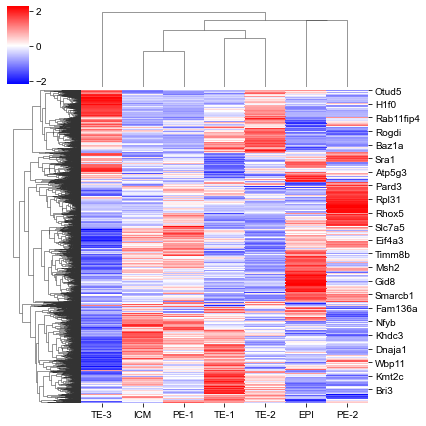

In [35]:
sns.clustermap(m, z_score=0, cmap="bwr", figsize=(6, 6))

In [6]:
def load_quant_gene(path):
    d1 = pd.read_csv(path, sep="\t", index_col=0)
    d1["TPM"] = d1["Total"] * 1e6 / sum(d1["Total"])
    d2 = d1.merge(anno_g, left_index=True, right_index=True)
    d2 = d2[~d2["GeneName"].duplicated()]
    d2.index = d2["GeneName"]
    return d2

def load_quant_transcript(path):
    d1 = pd.read_csv(path, sep="\t", index_col=0)
    d1["TPM"] = d1["Total"] * 1e6 / sum(d1["Total"])
    d2 = d1.merge(anno_t, left_index=True, right_index=True)
    return d2

/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


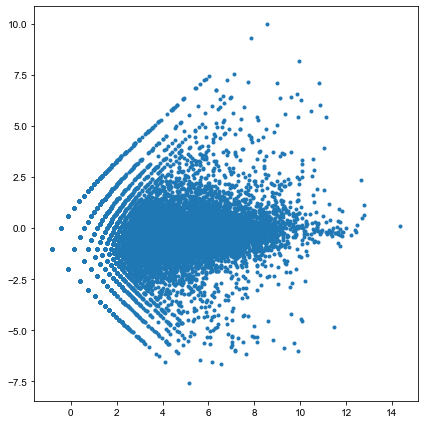

In [135]:
ct1 = "EPI-2"
ct2 = "TE-3"

m1 = load_quant_gene("expression/quant_gene.%s.tsv" % ct1)
s1 = m1["TPM"]
s1.name = ct1

m2 = load_quant_gene("expression/quant_gene.%s.tsv" % ct2)
s2 = m2["TPM"]
s2.name = ct2

m = pd.concat([s1, s2], axis=1).fillna(0)
m["Mean"] = m.mean(axis=1)
m["Log2FC"] = np.log2(m[ct2] / m[ct1])
m = m[np.isfinite(m["Log2FC"])]

xs = m["Mean"]
xs = np.log2(xs)
ys = m["Log2FC"]

plt.figure(figsize=(6, 6))
plt.scatter(xs, ys, marker=".")
plt.tight_layout()
plt.show()

In [136]:
m[(m["Mean"] > 100) & (m["Log2FC"] > 5)]

,EPI-2,TE-3,Mean,Log2FC
Id2,29.795203,983.144771,506.469987,5.044252
Plet1,12.662961,541.966400,277.314681,5.419517
Gm2a,43.203044,1864.024765,953.613904,5.431144
Gata3,14.152721,558.948999,286.550860,5.303565
Tspan1,2.979520,203.791180,103.385350,6.095868
BC053393,26.815682,2098.458460,1062.637071,6.290109
AA467197,17.877122,1546.154826,782.015974,6.434427
Krt8,52.141605,2790.314750,1421.228177,5.741849
Tacstd2,1.489760,272.459948,136.974854,7.514820
Lgals1,26.070802,3560.069481,1793.070142,7.093327


In [129]:
m1 = m[(m["Mean"] > 300) & (m["Log2FC"].abs() < 2)]

for gname in m1.index:
    # print(gname)
    
    tmp1 = mt1[mt1["GeneName"] == gname].sort_values(by="TPM", ascending=False)
    if len(tmp1) == 0:
        continue
    tid1 = tmp1.index.values[0]
    r1 = tmp1["Total"].values[0] / sum(tmp1["Total"])
    
    tmp2 = mt2[mt2["GeneName"] == gname].sort_values(by="TPM", ascending=False)
    if len(tmp2) == 0:
        continue
    tid2 = tmp2.index.values[0]
    r2 = tmp2["Total"].values[0] / sum(tmp2["Total"])
    
    if r1 > 0.5 and r2 > 0.5 and tid1 != tid2:
        print(gname)
        break
    
    # break

Hdlbp


In [32]:
ct1, ct2 = "TE-3", "PE"

mt1 = load_quant_transcript("expression/quant_transcript.%s.tsv" % ct1)
mt2 = load_quant_transcript("expression/quant_transcript.%s.tsv" % ct2)
tmp1 = mt1[['Total', 'Total.P', 'Total.M', 'Nascent', 'Nascent.P', 'Nascent.M', 'TPM']]
mt = tmp1.merge(mt2, left_index=True, right_index=True, suffixes=["_1", "_2"])

for gname, tmp in mt.groupby(by="GeneName"):
    
    tmp1 = tmp.sort_values(by="Total_1", ascending=False)
    tid1 = tmp1.index.values[0]
    count1 = tmp1["Total_1"].values[0]
    ratio1 = count1 / sum(tmp1["Total_1"])
    
    tmp2 = tmp.sort_values(by="Total_2", ascending=False)
    tid2 = tmp2.index.values[0]
    count2 = tmp2["Total_2"].values[0]
    ratio2 = count2 / sum(tmp2["Total_2"])
    
    if count1 > 30 and count2 > 30 and ratio1 > 0.6 and ratio2 > 0.6 and tid1 != tid2:
        print(gname)
        # break

Lrr1
Tpm1
Tsen34


In [34]:
tmp = mt[mt["GeneName"] == "Tpm1"]
tmp

,Total_1,Total.P_1,Total.M_1,Nascent_1,Nascent.P_1,Nascent.M_1,TPM_1,Total_2,Total.P_2,Total.M_2,...,TPM_2,TranscriptType,GeneID,GeneType,GeneName,Chrom,Start,End,Strand,Canonical
TranscriptID,,,,,,,,,,,,,,,,,,,,,
ENSMUST00000113695.7,86.0,44.0,38.0,27.0,13.0,12.0,65.392079,3.0,2.0,1.0,...,2.954248,protein_coding,ENSMUSG00000032366.15,protein_coding,Tpm1,chr9,67022591,67043802,-,False
ENSMUST00000113696.7,469.0,230.0,210.0,152.0,86.0,56.0,356.614941,12.0,5.0,6.0,...,11.816990,protein_coding,ENSMUSG00000032366.15,protein_coding,Tpm1,chr9,67022589,67043907,-,False
ENSMUST00000113697.7,62.0,39.0,17.0,21.0,12.0,6.0,47.143127,1.0,0.0,1.0,...,0.984749,protein_coding,ENSMUSG00000032366.15,protein_coding,Tpm1,chr9,67022614,67049275,-,False
ENSMUST00000113684.7,49.0,0.0,0.0,10.0,0.0,0.0,37.258277,37.0,0.0,0.0,...,36.435720,protein_coding,ENSMUSG00000032366.15,protein_coding,Tpm1,chr9,67028047,67043733,-,False


In [31]:
tmp[["Total_1", "Nascent_1", "Total_2", "Nascent_2"]]

,Total_1,Nascent_1,Total_2,Nascent_2
TranscriptID,,,,
ENSMUST00000113696.7,110.0,13.0,12.0,3.0
ENSMUST00000113684.7,45.0,9.0,37.0,15.0
ENSMUST00000113695.7,10.0,1.0,3.0,2.0


# Halflife of cell types

In [2]:
anno_g = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.genes.tsv", sep="\t", index_col=2)

In [3]:
dat = pd.read_csv("seurat_outputs/seurat_metadata_active_ident.tsv", sep="\t")
dat = dat[np.isnan(dat["ActD"])]
dat.index = dat["Cell"]
cts = ['TE-1', 'TE-2', 'TE-3', 'ICM', "EPI", "PE-1", "PE-2"]

In [11]:
for ct in cts:
    d = dat[(dat["Time"] == 3) & (dat["s4U"] == 400) & (dat["CellType"] == ct)]
    array_total = []
    array_nascent = []
    for run, cell in d[["Run", "Cell"]].values:
        path = "../../1_NanoNASCseq/results/expression/quantify/2TC/%s/%s/quant_gene.tsv.gz" % (run, cell)
        expr = pd.read_csv(gzip.open(path, "rt"), sep="\t", index_col=0)
        s = expr["Total"]
        s.name = cell
        array_total.append(s)
        s = expr["Nascent"]
        s.name = cell
        array_nascent.append(s)
    d_total = pd.concat(array_total, axis=1).fillna(0)
    s_total = d_total.sum(axis=1)
    s_total.name = "Total"
    d_nascent = pd.concat(array_nascent, axis=1).fillna(0)
    s_nascent = d_nascent.sum(axis=1)
    s_nascent.name = "Nascent"
    d_merged = pd.concat([s_total, s_nascent], axis=1).fillna(0)
    d_merged.index.name = "GeneID"
    d_merged["TPM"] = d_merged["Total"] * 1e6 / d_merged["Total"].sum()
    d_merged["NTR"] = d_merged["Nascent"] / d_merged["Total"]
    d_merged["T"] = -3 / np.log2(1 - d_merged["NTR"])
    d_merged["K"] = d_merged["TPM"] * np.log(2) / d_merged["T"]
    d_merged = d_merged.merge(anno_g, left_index=True, right_index=True, how="inner")
    d_merged.to_csv("halflife/%s.tsv" % ct, sep="\t")
    #break

/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chen

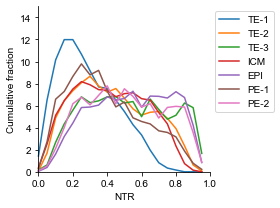

In [12]:
def get_xy(vs):
    w = 0.05
    xmax = 1
    xs = np.arange(0, xmax, w)
    ys = np.zeros(int(xmax / w))
    for v in vs:
        i = int(v / w)
        if i < len(ys):
            ys[i] += 1
    ys = ys * 100 / len(vs)
    return xs, ys


plt.figure(figsize=(4, 3))
for ct in cts:
    d = pd.read_csv("halflife/%s.tsv" % ct, sep="\t", index_col=0)
    d = d[(d["GeneType"] == "protein_coding") & (d["Total"] >= 50) & (d["Nascent"] > 0) & (d["Nascent"] < d["Total"])]
    # xs, ys = get_xy(np.log2(d["T"]))
    xs, ys = get_xy(d["NTR"])
    plt.plot(xs, ys, label=ct, clip_on=False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("NTR")
plt.ylabel("Cumulative fraction")
plt.xlim(0, 1)
plt.ylim(0, 15)
plt.legend(ncol=1, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# plt.savefig("figures/ntr_cumulative_fraction.pdf", dpi=300)

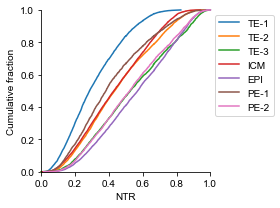

In [13]:
def get_xy(vs):
    xs = np.array(list(sorted(vs)))
    ys = np.arange(0, len(xs)) / len(xs)
    return xs, ys

plt.figure(figsize=(4, 3))
for ct in cts:
    d = pd.read_csv("halflife/%s.tsv" % ct, sep="\t", index_col=0)
    d = d[(d["GeneType"] == "protein_coding") & (d["Total"] >= 50)]
    xs, ys = get_xy(d["NTR"])
    plt.plot(xs, ys, label=ct, clip_on=False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("NTR")
plt.ylabel("Cumulative fraction")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(ncol=1, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("figures/ntr_cumulative_fraction.pdf", dpi=300)

In [14]:
m = np.zeros((len(cts), len(cts)))
for i in range(len(cts)):
    for j in range(len(cts)):
        if i < j:
            r = 0
            
            ct = cts[i]
            d = pd.read_csv("halflife/%s.tsv" % ct, sep="\t", index_col=0)
            d = d[(d["GeneType"] == "protein_coding") & (d["Total"] >= 50)]
            s1 = d["NTR"]
            
            ct = cts[j]
            d = pd.read_csv("halflife/%s.tsv" % ct, sep="\t", index_col=0)
            d = d[(d["GeneType"] == "protein_coding") & (d["Total"] >= 50)]
            s2 = d["NTR"]
            
            d = pd.concat([s1, s2], axis=1, join="inner")
            r = d.corr().values[0][1]
            
            m[i][j] = r
            m[j][i] = r
        elif i == j:
            m[i][j] = 1
            
m = pd.DataFrame(m, index=cts, columns=cts)

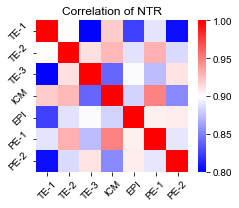

In [15]:
plt.figure(figsize=(3.5, 3))
plt.title("Correlation of NTR")
sns.heatmap(m, cmap="bwr", vmin=0.8, vmax=1)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/ntr_correlation_heatmap.pdf", dpi=300)

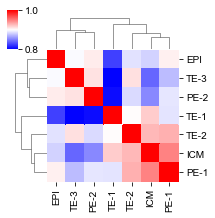

In [16]:
ret = sns.clustermap(m, figsize=(3, 3), cmap="bwr", vmin=0.8, vmax=1)
ret.fig.savefig("figures/ntr_correlation_clustermap.pdf", dpi=300)

In [207]:
array = []
for ct in cts:
    d = pd.read_csv("halflife/%s.tsv" % ct, sep="\t", index_col=0)
    d = d[(d["GeneType"] == "protein_coding") & (d["Total"] >= 50)]
    s = d["NTR"]
    s.name = ct
    array.append(s)
d = pd.concat(array, axis=1, join="inner")
d.index = anno_g.loc[d.index]["GeneName"]
print(len(d))

2570


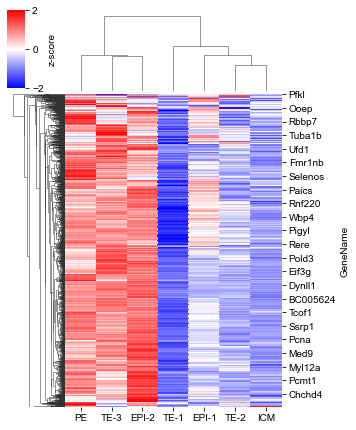

In [219]:
sns.clustermap(d, z_score=0, cmap="bwr", vmin=-2, vmax=2, figsize=(5, 6), cbar_kws={"label": "z-score"})

# Comparison of change of K and A0

In [4]:
anno_g = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.genes.tsv", sep="\t", index_col=2)
dat = pd.read_csv("seurat_outputs/seurat_metadata_active_ident.tsv", sep="\t")
dat = dat[np.isnan(dat["ActD"])]
dat.index = dat["Cell"]
cts = ['TE-1', 'TE-2', 'TE-3', 'ICM', "EPI", "PE-1", "PE-2"]

In [9]:
data = dict()
for ct in cts:
    d = dat[(dat["CellType"] == ct) & (dat["s4U"] == 400) & (dat["Time"] == 3)]
    print(ct, len(d), sep="\t")

    array1 = []
    array2 = []
    for run, cell in d[["Run", "Cell"]].values:
        path = "../../1_NanoNASCseq/results/expression/quantify.v2/2TC/%s/%s/quant_gene.tsv.gz" % (run, cell)
        df = pd.read_csv(gzip.open(path, "rt"), sep="\t", index_col=0)
        df = df.merge(anno_g, left_index=True, right_index=True)
        # df = df[df["Canonical"]]
        df = df[~df["GeneName"].duplicated()]
        df.index = df["GeneName"]
        s1 = df["Total"]
        s1.name = cell
        s2 = df["Nascent"]
        s2.name = cell
        array1.append(s1)
        array2.append(s2)
    s1 = pd.concat(array1, axis=1, sort=False).fillna(0).sum(axis=1)
    s1.name = "Total"
    s2 = pd.concat(array2, axis=1, sort=False).fillna(0).sum(axis=1)
    s2.name = "Nascent"
    df = pd.concat([s1, s2], axis=1)
    df["NTR"] = df["Nascent"] / df["Total"]
    df = df[(df["Total"] >= 20) & (df["Nascent"] > 0) & (df["Nascent"] < df["Total"])]
    data[ct] = df

TE-1	204
TE-2	211
TE-3	124
ICM	434
EPI	200
PE-1	87
PE-2	112


In [11]:
for ct, df in data.items():
    df["TPM"] = df["Total"] * 1e6 / df["Total"].sum()
    df["T"] = -3 / np.log2(1 - (df["Nascent"] / df["Total"]))
    df["K"] = df["TPM"] * np.log(2) / df["T"]

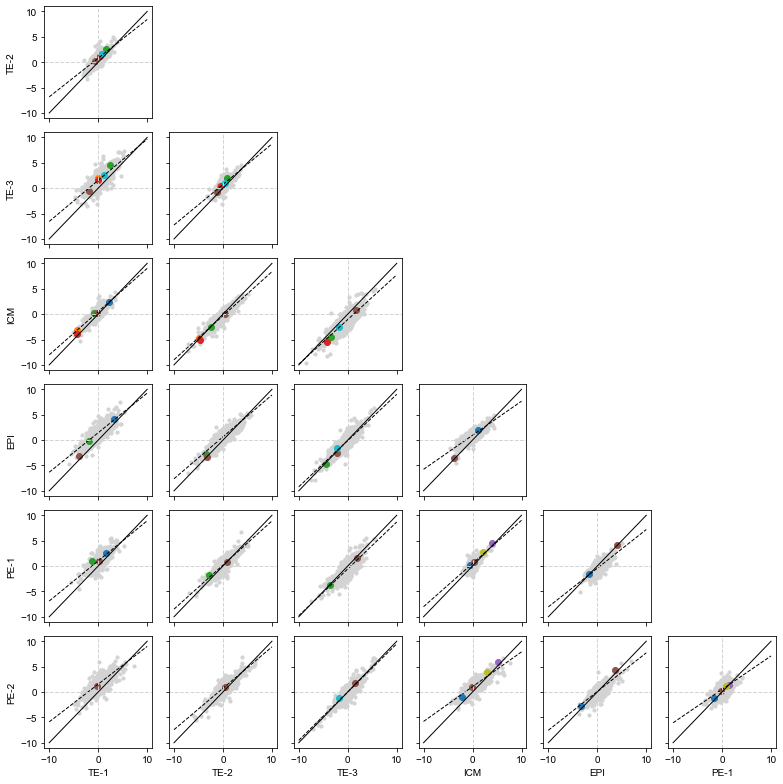

In [41]:
fig, axs = plt.subplots(len(cts) - 1, len(cts) - 1, figsize=(11, 11), 
                        sharex=True, sharey=True, 
                        #gridspec_kw={"hspace": 0.1, "wspace": 0.1}
                       )

genes = ["Sox2", "Cdx2", "Eomes", "Gata3", "Gata4", "Gata6", "Gapdh", "Sox17", "Pdlim5"]
colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C8", "C9"]
    
for i in range(len(cts) - 1):
    for j in range(len(cts) - 1):
        ax = axs[j][i]
        if i > j:
            ax.set_visible(False)
            continue
        
        plt.sca(ax)
        
        ct1 = cts[i]
        ct2 = cts[j + 1]
        df1 = data[ct1]
        df2 = data[ct2]
        df = df1.merge(df2, left_index=True, right_index=True, suffixes=["_1", "_2"])
        df["Mean_TPM"] = df[["TPM_1", "TPM_2"]].mean(axis=1)
        df["Log2FC_TPM"] = np.log2(df["TPM_2"] / df["TPM_1"])
        df["Log2FC_K"] = np.log2(df["K_2"] / df["K_1"])
        df = df[np.isfinite(df["Log2FC_TPM"])]
        df = df[np.isfinite(df["Log2FC_K"])]
        df = df[df["Mean_TPM"] > 50]

        xs = df["Log2FC_TPM"].values
        ys = df["Log2FC_K"].values
        a, b = 0, 0
        try:
            a, b = np.polyfit(xs, ys, 1)
        except Exception:
            pass

        plt.scatter(xs, ys, alpha=1, s=10, color="lightgrey")
        
        for m, gname in enumerate(genes):
            try:
                row = df.loc[gname]
                x, y = row["Log2FC_TPM"], row["Log2FC_K"]
                plt.scatter([x], [y], color=colors[m], label=gname)
            except:
                pass

        xs1 = [-10, 10]
        ys1 = [a * x + b for x in xs1]
        plt.plot(xs1, ys1, lw=1, color="black", ls="--")
        plt.axvline(0, lw=1, ls="--", color="lightgrey")
        plt.axhline(0, lw=1, ls="--", color="lightgrey")
        plt.plot([-10, 10], [-10, 10], ls="-", lw=1, color="black")

        if i == 0:
            plt.ylabel(ct2)
            
        #if j != len(cts) - 1:
        #    plt.xticks([])
        #if i != 0:
        #    plt.yticks([])
        
        if j == len(cts) - 2:
            plt.xlabel(ct1)
            

        
plt.tight_layout()
# plt.show()
plt.savefig("figures/blastocyst_dynamic_tmp_vs_synthesis.pdf", dpi=300)

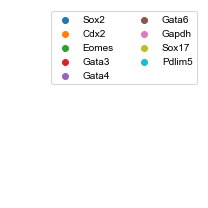

In [28]:
plt.figure(figsize=(3, 3))
for g, c in zip(genes, colors):
    plt.scatter(0, 0, color=c, label=g)
plt.xlim(1, 2)
plt.legend(ncol=2)
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("figures/blastocyst_dynamic_tmp_vs_synthesis.legend.pdf", dpi=300)

# Labeling efficient

In [2]:
dat = pd.read_csv("results/blastocyst/seurat_metadata.cell_type.tsv", sep="\t")
dat = dat[(dat["s4U"] == 400) & (dat["Time"] == 3)]
print(len(dat))
print(Counter(dat["CellType"]))

1904
Counter({'ICM-2': 373, 'PE': 283, 'TE-3': 257, 'TE-1': 196, 'EPI-2': 164, 'EPI-1': 162, 'ICM-1': 147, 'TE-2': 140, 'TE-4': 92, 'Unknown': 57, 'Molura': 33})


In [3]:
cts = list(sorted(set(dat["CellType"])))
cts = ['Molura', 'ICM-1', 'ICM-2', 'EPI-1', 'EPI-2', 'PE', 'TE-1', 'TE-2', 'TE-3', 'TE-4']

In [5]:
mismatch_ratios = dict()
for run, cell in dat[["Run", "Cell"]].values:
    path = "results/nascent/ratio/%s/%s/ratio.ce.tsv" % (run, cell)
    df = pd.read_csv(path, sep="\t", index_col=0)
    mismatch_ratios[cell] = df["Ratio"]["TC"]

In [42]:
label_efficiencies = dict()
for run, cell in dat[["Run", "Cell"]].values:
    path = "results/nascent/marked_nascent/%s/%s_metrics.txt" % (run, cell)
    df = pd.read_csv(path, sep="\t", header=None)
    df = df[(df[4] >= 2) & (df[8] >= 1)]
    label_efficiencies[cell] = df[8] / df[7]

0	Molura	15	18
1	ICM-1	33	114
2	ICM-2	77	296
3	EPI-1	34	128
4	EPI-2	18	146
5	PE	48	235
6	TE-1	29	167
7	TE-2	16	124
8	TE-3	25	232
9	TE-4	7	85


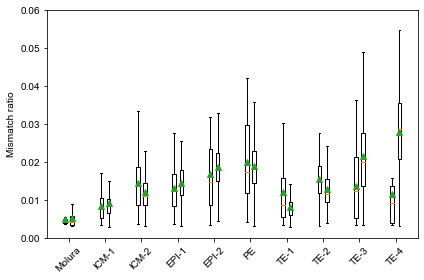

In [31]:
xs = np.arange(len(cts))
array = []
plt.figure(figsize=(6, 4))
for i, ct in enumerate(cts):
    d = dat[dat["CellType"] == ct]
    d1 = d[[not s.endswith("X") for s in d["Strain"]]]
    d2 = d[[s.endswith("X") for s in d["Strain"]]]
    vs1 = [mismatch_ratios[cell] for cell in d1["Cell"]]
    vs2 = [mismatch_ratios[cell] for cell in d2["Cell"]]
    print(i, ct, len(d1), len(d2), sep="\t")
    plt.boxplot([vs1, vs2], positions=[i - 0.1, i + 0.1], widths=0.1, showfliers=False, showmeans=True)
plt.xticks(xs, cts, rotation=45)
plt.ylim(0, 0.06)
plt.ylabel("Mismatch ratio")
plt.tight_layout()
plt.show()

0	Molura	15	18
1	ICM-1	33	114
2	ICM-2	77	296
3	EPI-1	34	128
4	EPI-2	18	146
5	PE	48	235
6	TE-1	29	167
7	TE-2	16	124
8	TE-3	25	232
9	TE-4	7	85


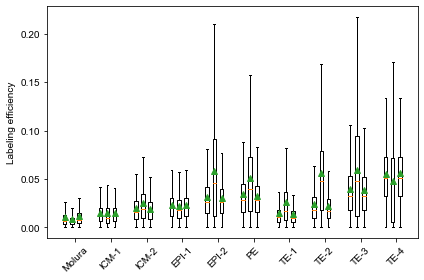

In [43]:
def flatten(array):
    vs = []
    for vs1 in array:
        vs.extend(vs1)
    return vs
    
xs = np.arange(len(cts))
array = []
plt.figure(figsize=(6, 4))
for i, ct in enumerate(cts):
    d = dat[dat["CellType"] == ct]
    d1 = d[[not s.endswith("X") for s in d["Strain"]]]
    d2 = d[[s.endswith("X") for s in d["Strain"]]]
    print(i, ct, len(d1), len(d2), sep="\t")
    vs0 = flatten([label_efficiencies[cell] for cell in d["Cell"]])
    vs1 = flatten([label_efficiencies[cell] for cell in d1["Cell"]])
    vs2 = flatten([label_efficiencies[cell] for cell in d2["Cell"]])
    plt.boxplot([vs0, vs1, vs2], positions=[i - 0.3, i - 0.1, i + 0.1],  widths=0.1, showfliers=False, showmeans=True)
plt.xticks(xs, cts, rotation=45)
# plt.ylim(0, 0.06)
plt.ylabel("Labeling efficiency")
plt.tight_layout()
plt.show()

In [2]:
# 

In [13]:
dat = pd.read_csv("results/blastocyst/seurat_metadata.cell_type.tsv", sep="\t")
counter = dict()
for s4u, time, strain, celltype in dat[["s4U", "Time", "Strain", "CellType"]].values:
    celltype = celltype.split("-")[0]
    if strain.endswith("X"):
        s = 1
    else:
        s = 0
    k = (s4u, time, celltype)
    if k not in counter:
        counter[k] = [0, 0]
    counter[(s4u, time, celltype)][s] += 1
rows = []
for (s4u, time, ct), (count1, count2) in counter.items():
    rows.append([s4u, time, ct, count1, count2])
d = pd.DataFrame(rows)
d.columns = ["s4U", "Time", "CellType", "Count", "CountX"]
d.to_excel("results/cell_type.count.xlsx", index=False)

# Quantitative

In [2]:
anno_t = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.annotation.tsv", sep="\t", index_col=0)
anno_g = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.genes.tsv", sep="\t", index_col=2)

In [3]:
dat = pd.read_csv("seurat_outputs/seurat_metadata_active_ident.tsv", sep="\t")
dat = dat[(dat["s4U"] == 400) & (dat["Time"] == 3) & (np.isnan(dat["ActD"]))]
len(dat)

1424

In [29]:
tmp = pd.read_excel("data/nature23262-s1/Table S7. List of putative H3K27me3-dependent imprinted genes.xlsx")
gnames = list(tmp["gene_name"])
print(len(gnames))

76


In [31]:
tmp = pd.read_excel("data/nature23262-s1/Table S1. Ps-DHSs, Ms-DHSs, and bi-allelic DHSs in zygotes.xlsx")
gnames = list(tmp["Nearst gene"])
print(len(gnames))

688


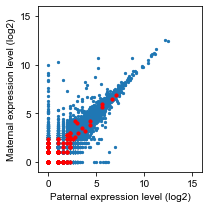

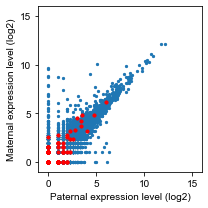

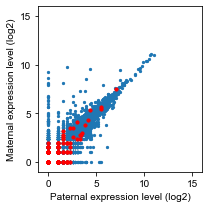

In [32]:
for ct in ["EPI", "TE-3", "PE-2"]:
    d = dat[(dat["CellType"] == ct) & (dat["s4U"] == 400) & (dat["Time"] == 3) & (np.isnan(dat["ActD"]))]
    len(d)
    
    m = pd.read_csv("expression/cell_types/quant_transcript.%s.tsv" % ct, sep="\t", index_col=0)
    m.columns = ['Total', 'Total.M', 'Total.P', 'Nascent', 'Nascent.M', 'Nascent.P']
    m = m.merge(anno_t, left_index=True, right_index=True)
    m["NTR.P"] = m["Nascent.P"] / m["Total.P"]
    m["NTR.M"] = m["Nascent.M"] / m["Total.M"]

    xs = m["Total.P"] # paternal
    ys = m["Total.M"] # maternal
    xs = np.log2(xs + 1)
    ys = np.log2(ys + 1)
    
    m1 = m[[gname in gnames for gname in m["GeneName"]]]
    xs1 = m1["Total.P"] # paternal
    ys1 = m1["Total.M"] # maternal
    xs1 = np.log2(xs1 + 1)
    ys1 = np.log2(ys1 + 1)
    
    plt.figure(figsize=(3, 3))
    plt.scatter(xs, ys, marker="o", s=5, color="C0")
    plt.scatter(xs1, ys1, marker="o", s=10, color="red")
    plt.xlim(-1, 16)
    plt.ylim(-1, 16)
    plt.xlabel("Paternal expression level (log2)")
    plt.ylabel("Maternal expression level (log2)")
    plt.xticks([0, 5, 10, 15])
    plt.yticks([0, 5, 10, 15])
    plt.tight_layout()
    plt.show()
    
    # break

## Old

In [37]:
dat = pd.read_csv("seurat_outputs/seurat_metadata_active_ident.tsv", sep="\t")
data = dict()
for run, cell in dat[["Run", "Cell"]].values:
    path = "results/nascent/quant_transcript.patmat/%s/%s.tsv" % (run, cell)
    data[cell] = pd.read_csv(path, sep="\t", index_col=0)

In [38]:
d = dat[(dat["s4U"] == 400) & (dat["Time"] == 3) & (np.isnan(dat["ActD"])) & (dat["TC"] > 0.015)]
d = d[[x.startswith("EPI") for x in d["CellType"]]]
len(d)

139

In [39]:
def make_matrix(cells, data, anno):
    counter = dict()
    for cell in cells:
        d = data[cell]
        for tid, vs in zip(d.index, d.values):
            if tid not in counter:
                counter[tid] = np.zeros(6)
            counter[tid] += vs
    tids = []
    rows = []
    for k, v in counter.items():
        tids.append(k)
        rows.append(v)
    m = pd.DataFrame(rows, 
                     index=pd.Index(tids, name="TranscriptID"), 
                     columns=["Total", "Total.M", "Total.P", "Nascent", "Nascent.M", "Nascent.P"]) # C57 is maternal, DBA is paternal
    m["NTR"] = m["Nascent"] / m["Total"]
    m["NTR.P"] = m["Nascent.P"] / m["Total.P"]
    m["NTR.M"] = m["Nascent.M"] / m["Total.M"]
    m["Total.PM"] = m["Total.P"] + m["Total.M"]
    m["Log2FC_PM"] = np.log2(m["Total.P"] / m["Total.M"])
    return m
m = make_matrix(d["Cell"], data, anno)
m = m.merge(anno1, left_index=True, right_index=True)

/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log2


In [46]:
gids = []
rows = []
for gid, m1 in m.groupby(by="GeneID"):
    m1 = m1[m1["Total"] >= 20]
    if len(m1) < 2:
        continue
    m1 = m1.sort_values(by="Total", ascending=False)
    gids.append(gid)
    total1, total2 = m1["Total"].values[:2]
    nascent1, nascent2 = m1["Nascent"].values[:2]
    ntr1, ntr2 = m1["NTR"].values[:2]
    tt1, tt2 = m1["TranscriptType"].values[:2]
    rows.append([total1, total2, nascent1, nascent2, ntr1, ntr2, tt1, tt2])

In [51]:
d1 = pd.DataFrame(rows, 
                  index=pd.Index(gids, name="GeneID"), 
                  columns=["Total1", "Total2", "Nascent1", "Nascent2", "NTR1", "NTR2", "TranscriptType1", "TranscriptType2"])
d1["Diff"] = d1["NTR1"] - d1["NTR2"]
d1["Diff.abs"] = abs(d1["Diff"])
d1 = d1.sort_values(by="Diff.abs", ascending=False)
d1 = d1.merge(anno2, left_index=True, right_index=True)
d1.to_csv("results/blastocyst/isoform_decay_deversity.EPI.tsv", sep="\t")

In [53]:
", ".join(d1["GeneName"].values[:50])

'Rps18, Hnrnpa1, Mrpl57, Rps19, Rpl18, Rpl10a, Gna13, Fis1, Rpl36a, Znhit1, Myl6, Aldoa, Rpl13a, Erh, Rpl18a, Rps27l, Mrps16, Ptma, Rpl35, Aurkaip1, Tma16, Mtch2, Btf3, Srp9, Anapc16, Tpm1, Ndufs8, Gpx4, Fmr1nb, Pigyl, Rps20, Eno1, Set, Eif5a, Actg1, Gpx2, Gfer, Wdr83os, Szrd1, Rps5, Idh3g, Rpl31, Hnrnpk, Aimp2, Prxl2a, Uqcr10, Hmgb3, Trappc1, Sra1, Rpl37a'

In [42]:
m[m["GeneID"] == "ENSMUSG00000008668.15"].sort_values(by="Total", ascending=False)

,Total,Total.M,Total.P,Nascent,Nascent.M,Nascent.P,NTR,NTR.P,NTR.M,Total.PM,Log2FC_PM,TranscriptType,GeneID,GeneType,GeneName,Chrom,Start,End,Strand,Canonical
TranscriptID,,,,,,,,,,,,,,,,,,,,
ENSMUST00000008812.8,1068.0,1032.0,31.0,170.0,167.0,3.0,0.159176,0.096774,0.161822,1063.0,-5.057031,protein_coding,ENSMUSG00000008668.15,protein_coding,Rps18,chr17,33951998,33955677,-,True
ENSMUST00000234380.1,23.0,6.0,17.0,21.0,5.0,16.0,0.913043,0.941176,0.833333,23.0,1.502500,nonsense_mediated_decay,ENSMUSG00000008668.15,protein_coding,Rps18,chr17,33951998,33955663,-,False
ENSMUST00000174745.7,21.0,8.0,13.0,4.0,1.0,3.0,0.190476,0.230769,0.125000,21.0,0.700440,processed_transcript,ENSMUSG00000008668.15,protein_coding,Rps18,chr17,33951998,33955212,-,False
ENSMUST00000174620.2,20.0,10.0,10.0,18.0,9.0,9.0,0.900000,0.900000,0.900000,20.0,0.000000,retained_intron,ENSMUSG00000008668.15,protein_coding,Rps18,chr17,33952001,33955653,-,False
ENSMUST00000174609.8,18.0,5.0,12.0,3.0,0.0,3.0,0.166667,0.250000,0.000000,17.0,1.263034,protein_coding,ENSMUSG00000008668.15,protein_coding,Rps18,chr17,33951998,33955663,-,False
ENSMUST00000172799.7,8.0,4.0,4.0,8.0,4.0,4.0,1.000000,1.000000,1.000000,8.0,0.000000,processed_transcript,ENSMUSG00000008668.15,protein_coding,Rps18,chr17,33951999,33954490,-,False
ENSMUST00000173323.1,3.0,1.0,2.0,3.0,1.0,2.0,1.000000,1.000000,1.000000,3.0,1.000000,retained_intron,ENSMUSG00000008668.15,protein_coding,Rps18,chr17,33952003,33952541,-,False
ENSMUST00000174175.7,3.0,2.0,1.0,3.0,2.0,1.0,1.000000,1.000000,1.000000,3.0,-1.000000,retained_intron,ENSMUSG00000008668.15,protein_coding,Rps18,chr17,33951999,33955660,-,False
ENSMUST00000174662.1,1.0,0.0,1.0,1.0,0.0,1.0,1.000000,1.000000,NaN,1.0,inf,retained_intron,ENSMUSG00000008668.15,protein_coding,Rps18,chr17,33954824,33955660,-,False


4 31


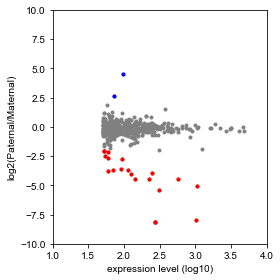

In [65]:
m1 = m[m["Total.PM"] >= 50]

xs = m1["Total.PM"]
ys = m1["Log2FC_PM"]
xs = np.log10(xs)

xs1, ys1 = xs[ys>2], ys[ys>2]
xs2, ys2 = xs[ys<-2], ys[ys<-2]
print(len(xs1), len(xs2))

plt.figure(figsize=(4, 4))
plt.scatter(xs, ys, marker=".", color="grey")
plt.scatter(xs1, ys1, marker=".", color="blue")
plt.scatter(xs2, ys2, marker=".", color="red")
plt.xlim(1, 4)
plt.ylim(-10, 10)
plt.xlabel("expression level (log10)")
plt.ylabel("log2(Paternal/Maternal)")
plt.tight_layout()
plt.savefig("results/blastocyst/isoform_parental_diff_expressed.EPI.pdf", dpi=300)

In [69]:
m1[(m1["Log2FC_PM"] > 2) | (m1["Log2FC_PM"] < -2)].to_csv("results/blastocyst/isoform_parental_diff_expressed.EPI.tsv", sep="\t")

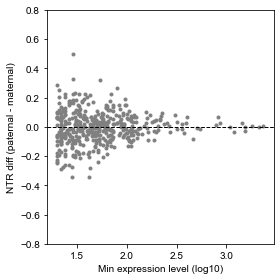

In [90]:
m2 = m[(m["Total.P"] >= 20) & (m["Total.M"] >= 20)].copy()
m2["NTR.Diff"] = m2["NTR.P"] - m2["NTR.M"]
m2.to_csv("results/blastocyst/allele_specific_decay_rate.EPI.tsv", sep="\t")
xs = m2[["Total.P", "Total.M"]].min(axis=1)
ys = m2["NTR.Diff"]
xs = np.log10(xs)

plt.figure(figsize=(4, 4))
plt.scatter(xs, ys, marker=".", color="grey")
plt.axhline(0, lw=1, ls="--", color="black")
plt.ylim(-0.8, 0.8)
plt.xlabel("Min expression level (log10)")
plt.ylabel("NTR diff (paternal - maternal)")
plt.tight_layout()
plt.savefig("results/blastocyst/allele_specific_decay_rate.EPI.pdf", dpi=300)

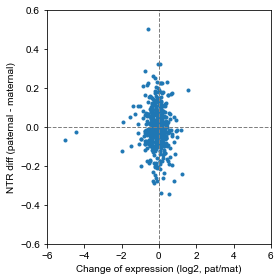

In [100]:
xs = m2["Log2FC_PM"]
ys = m2["NTR.Diff"]

plt.figure(figsize=(4, 4))
plt.scatter(xs, ys, marker=".")
plt.xlim(-6, 6)
plt.ylim(-0.6, 0.6)
plt.axhline(0, lw=1, ls="--", color="grey")
plt.axvline(0, lw=1, ls="--", color="grey")
plt.xlabel("Change of expression (log2, pat/mat)")
plt.ylabel("NTR diff (paternal - maternal)")
plt.tight_layout()
plt.savefig("results/blastocyst/allele_specific_expr_decay_rate.EPI.pdf", dpi=300)

# Gene expression in cell types

In [32]:
cts = ['EPI', 'ICM', 'Morula', 'PE-1', 'PE-2', 'TE-1', 'TE-2', 'TE-3']

In [33]:
data = dict()
for ct in cts:
    path = "expression/cell_types/quant_gene.%s.annotated.tsv" % ct
    ct = path.split("/")[-1].split(".")[1]
    d = pd.read_csv(path, sep="\t")
    d["TPM"] = d["Total"] * 1e6 / d["Total"].sum()
    data[ct] = d

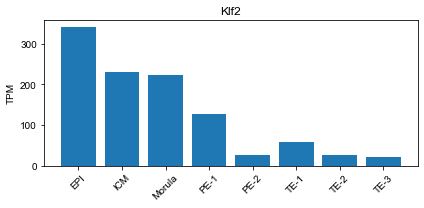

In [34]:
cts = list(sorted(data.keys()))
tpms = []
for ct in cts:
    d = data[ct]
    tpm = d[d["GeneName"] == "Klf2"]["TPM"].values[0]
    tpms.append(tpm)
xs = np.arange(len(cts))

plt.figure(figsize=(6, 3))
plt.title("Klf2")
plt.bar(xs, tpms)
plt.ylabel("TPM")
plt.xticks(xs, cts, rotation=45)
plt.tight_layout()
plt.show()

In [35]:
print(cts)

['EPI', 'ICM', 'Morula', 'PE-1', 'PE-2', 'TE-1', 'TE-2', 'TE-3']


# 20231126

In [4]:
dat1 = pd.read_csv("seurat_outputs/seurat_metadata_active_ident.tsv", sep="\t")
mapper = {k: v for k, v in dat1[["Cell", "CellType"]].values}
mapper

{'20220729_EmbryoR10.C02': 'TE-1',
 '20220729_EmbryoR10.C03': 'TE-1',
 '20220729_EmbryoR10.C05': 'ICM',
 '20220729_EmbryoR10.C06': 'ICM',
 '20220729_EmbryoR10.C07': 'ICM',
 '20220729_EmbryoR10.C08': 'ICM',
 '20220729_EmbryoR10.C09': 'TE-2',
 '20220729_EmbryoR10.C10': 'ICM',
 '20220729_EmbryoR10.C11': 'ICM',
 '20220729_EmbryoR10.C12': 'TE-1',
 '20220729_EmbryoR10.C13': 'ICM',
 '20220729_EmbryoR10.C14': 'TE-1',
 '20220729_EmbryoR10.C15': 'Morula',
 '20220729_EmbryoR10.C16': 'TE-1',
 '20220729_EmbryoR10.C17': 'Morula',
 '20220729_EmbryoR10.C18': 'ICM',
 '20220729_EmbryoR10.C19': 'TE-1',
 '20220729_EmbryoR10.C21': 'TE-2',
 '20220729_EmbryoR10.C22': 'ICM',
 '20220729_EmbryoR10.C23': 'ICM',
 '20220729_EmbryoR10.C24': 'ICM',
 '20220729_EmbryoR10.C25': 'TE-1',
 '20220729_EmbryoR10.C26': 'TE-1',
 '20220729_EmbryoR10.C27': 'TE-1',
 '20220729_EmbryoR10.C28': 'Morula',
 '20220729_EmbryoR10.C29': 'ICM',
 '20220729_EmbryoR10.C30': 'ICM',
 '20220729_EmbryoR10.C31': 'TE-1',
 '20220729_EmbryoR10.C32': 

In [8]:
dat2 = pd.read_csv("expression/mouse_blastocyst_transcript_meta.tsv", sep="\t")
dat2["CellType"] = [mapper.get(cell, "Unknown") for cell in dat2["Cell"]]
dat2.to_csv("expression/mouse_blastocyst_transcript_meta.celltype.tsv", sep="\t", index=False)